_____________________


## Dr. Pyrcz/Jack, may I request that you please hold off sharing this workflow till December 2021? I would like to explore this topic a little bit more for my research. Thank you. 

_____________________



### Prediction of Shear Strength Parameters using Machine Learning Techniques

#### Laide Ojomo
##### PhD Candidate, Geotechnical Engineering 
##### Cockrell School of Engineering, UT Austin
###### [LinkedIn](https://www.linkedin.com/in/olaide-ojomo-p-eng-pe-0057a97/)

_____________________



#### Subsurface Machine Learning Course, The University of Texas at Austin
##### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
##### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
###### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
###### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

The probability of occurrence of landslides need to be estimated to minimize potential damages and aid emergency response management plans. Shear strength parameters (consisting mainly of cohesion (kPa) and friction angle (degrees)) needed to estimate this probability are not readily available for analysis. This project attempts to predict shear strength parameters from geologic units and slope geometric properties using techniques and methods learnt in the subsurface machine learning course. Random Forest was selected as the preferred model to predict these parameters - the model accuracy was low, but this may be improved with the right set of predictor features.

### Import Packages

In [5]:
import numpy as np                                          # ndarrys for gridded data
import pandas as pd                                         # DataFrames for tabular data
import os                                                   # set working directory, run executables
import matplotlib.pyplot as plt                             # for plotting
from scipy import stats                                     # summary statistics
import math                                                 # trig etc.
import seaborn as sns                                       # for plotting
import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                      # GSLIB methods convert to Python        

#### Set working directory and load data

In [6]:
os.chdir(r'C:\Users\laide\Dropbox\PhD\2020\Fall Courses\GEO 391 26882 Subsurface Machine Learning\Project\study_area')
my_data = pd.read_csv("study_area_bh.csv")
my_data.head()

official_n     test_type   latitude   longitude       x        y  \
0   A-TSEC_F7265-80_1  Direct Shear  34.147506 -118.590343  353383  3779654   
1     ACEC_127001_TP1  Direct Shear  34.041081 -118.641577  348469  3767926   
2     ACEC_127001_TP2  Direct Shear  34.041085 -118.641510  348475  3767927   
3     ACEC_127001_TP2  Direct Shear  34.041085 -118.641510  348475  3767927   
4  ADECI_BG-136-90_BC  Direct Shear  34.142619 -118.528552  359072  3779025   

  geologic_unit  geologic_ID  cohesion  friction_angle  Vs30_Mean  \
0           Tsh           14      7.20            28.0      385.1   
1            Tv           16     17.76            19.0      518.9   
2            Tv           16     52.80            31.0      518.9   
3            Tv           16     34.56            28.0      518.9   
4   crystalline            3     43.20            37.5      710.1   

   slope_angle      aspect   elevation  flowline_curvature  general_curvature  \
0    11.404590   69.913895  340.157715            0.000071           0.004470   
1    17.923658  223.703247  116.392548           -0.000728          -0.023428   
2    21.327316  220.846649  118.476265           -0.000341          -0.040145   
3    21.327316  220.846649  118.476265           -0.000341          -0.040145   
4    21.496077   64.441605  350.563263            0.006030          -0.005612   

   plan_curvature  profile_curvature  total_curvature  
0        0.013357          -0.000433         0.000013  
1       -0.013017          -0.006463         0.000171  
2       -0.025920          -0.008045         0.000211  
3       -0.025920          -0.008045         0.000211  
4        0.029303          -0.011556         0.003362

This dataframe has a number of columns that are not required for this analysis. Remove these columns. 

In [7]:
drop_these = ['official_n', 'test_type', 'latitude', 'longitude'] #remove columns by names
my_data = my_data.drop(columns=drop_these)
my_data.head()

x        y geologic_unit  geologic_ID  cohesion  friction_angle  \
0  353383  3779654           Tsh           14      7.20            28.0   
1  348469  3767926            Tv           16     17.76            19.0   
2  348475  3767927            Tv           16     52.80            31.0   
3  348475  3767927            Tv           16     34.56            28.0   
4  359072  3779025   crystalline            3     43.20            37.5   

   Vs30_Mean  slope_angle      aspect   elevation  flowline_curvature  \
0      385.1    11.404590   69.913895  340.157715            0.000071   
1      518.9    17.923658  223.703247  116.392548           -0.000728   
2      518.9    21.327316  220.846649  118.476265           -0.000341   
3      518.9    21.327316  220.846649  118.476265           -0.000341   
4      710.1    21.496077   64.441605  350.563263            0.006030   

   general_curvature  plan_curvature  profile_curvature  total_curvature  
0           0.004470        0.013357          -0.000433         0.000013  
1          -0.023428       -0.013017          -0.006463         0.000171  
2          -0.040145       -0.025920          -0.008045         0.000211  
3          -0.040145       -0.025920          -0.008045         0.000211  
4          -0.005612        0.029303          -0.011556         0.003362

#### Visualize study area
Open and view geologic map

In [8]:
from PIL import Image
myImage = Image.open("point_dume_map.png");
display(myImage)

Here is a geologic map of the Point Dume area in California. The small green dots are the borehole sampling locations received from the California Geologic Survey.

#### Explore the dataset - Visualize shear strength parameters (cohesion and friction angle) in space
Set limits for plots

In [9]:
xmin = 3.27e+05; xmax = 3.62e+05               # range of x values
ymin = 3.765e+06; ymax = 3.79e+06               # range of y values
coh_min = 0.0; coh_max = 270;             # range of friction angle values
frict_min = 4.0; frict_max = 60;             # range of friction angle values
cmap = plt.cm.inferno                    # color map

Visualize shear strength parameters in space

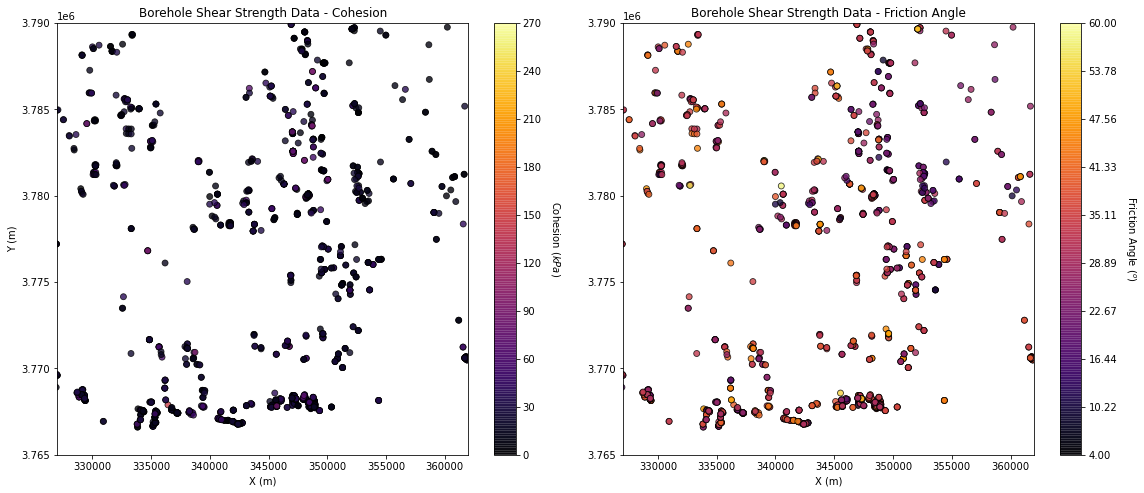

In [10]:
plt.subplot(121)
im = plt.scatter(my_data['x'],my_data['y'],c=my_data['cohesion'],cmap=cmap,vmin=coh_min,vmax=coh_max,
        alpha=0.8,linewidths=0.8,edgecolors="black")       # scatter plot for location map
plt.title('Borehole Shear Strength Data - Cohesion')                                    # add plot title
plt.xlim(xmin, xmax)                                                  # set x and y min and max
plt.ylim(ymin, ymax)
plt.xlabel('X (m)')                                                   # set axis labels
plt.ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(coh_min, coh_max, 10)) # add vertical color bar
cbar.set_label("Cohesion ($kPa$)", rotation=270, labelpad=20)      # add labels to the color bar

plt.subplot(122)
im = plt.scatter(my_data['x'],my_data['y'],c=my_data['friction_angle'],cmap=cmap,vmin=frict_min,vmax=frict_max,
        alpha=0.8,linewidths=0.8,edgecolors="black")       # scatter plot for location map
plt.title('Borehole Shear Strength Data - Friction Angle')                                    # add plot title
plt.xlim(xmin, xmax)                                                  # set x and y min and max
plt.ylim(ymin, ymax)
plt.xlabel('X (m)')                                                   # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(frict_min, frict_max, 10)) # add vertical color bar
cbar.set_label("Friction Angle ($^o$)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=1.0, right=2.5, top=2.5, wspace=0.1, hspace=0.2) # adjust the plot size

plt.show()

Most of the cohesion values are concentrated below 40 kPa with some outliers, friction angles are more distributed across the range of values. We can visualize the histograms for another view of the shear strength distribution. 

#### plot histograms to visualize the distribution of response features

In [11]:
coh_name = 'Cohesion (kPa)'; coh_title = 'Cohesion'; mean_coh = my_data['cohesion'].mean() 
frict_name = 'Friction Angle ($^o$)'; frict_title = 'Friction Angle'; mean_frict = my_data['friction_angle'].mean()

plt.subplot(121)
GSLIB.hist_st(my_data['cohesion'],0,130,log=False,cumul = False,bins=20, weights = None,xlabel=coh_name,title='')
plt.xlabel('Cohesion (kPa)',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.xlim(0, 130)
plt.ylim(0, 260)

plt.subplot(122)
GSLIB.hist_st(my_data['friction_angle'],0,65,log=False,cumul = False,bins=20, weights = None,xlabel=frict_name,title='')
plt.xlabel('Friction Angle ($^o$)',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.xlim(0, 65)
plt.ylim(0, 210)

plt.subplots_adjust(left=0.0, bottom=1.0, right=2.5, top=2.5, wspace=0.1, hspace=0.2)
plt.show()

Cohesion generally follows a lognormal distribution, the friction angle tends to follow a normal distribution

#### View summary statistics

In [12]:
my_data_ss = my_data.iloc[:,[3,4,5,7,8,9,10,11,12,13,14]]
my_data_ss.describe().transpose()

count        mean         std           min         25%  \
geologic_ID         1242.0   12.969404    3.479749  3.000000e+00   14.000000   
cohesion            1242.0   26.373797   20.774600  0.000000e+00   12.960000   
friction_angle      1242.0   31.624879    8.904227  4.000000e+00   26.000000   
slope_angle         1242.0   13.868948    9.076096  9.394199e-02    6.634713   
aspect              1242.0  167.697741   94.343827  2.317267e-01   85.653864   
elevation           1242.0  262.934434  151.798533  1.540201e+00  135.231888   
flowline_curvature  1242.0    0.000099    0.001489 -1.390015e-02   -0.000089   
general_curvature   1242.0    0.005758    0.049014 -2.610718e-01   -0.009288   
plan_curvature      1242.0    0.005209    0.067039 -4.443392e-01   -0.015250   
profile_curvature   1242.0    0.001263    0.012032 -4.413886e-02   -0.004541   
total_curvature     1242.0    0.000502    0.001038  8.088000e-12    0.000026   

                             50%         75%         max  
geologic_ID         1.400000e+01   15.000000   16.000000  
cohesion            2.160000e+01   33.600000  271.200000  
friction_angle      3.180000e+01   37.000000   58.200000  
slope_angle         1.266015e+01   20.257661   41.171879  
aspect              1.692589e+02  233.619980  359.408813  
elevation           2.779585e+02  346.080521  773.984558  
flowline_curvature  4.445120e-08    0.000131    0.011930  
general_curvature   2.097106e-03    0.026910    0.182923  
plan_curvature      6.427829e-03    0.023532    0.463227  
profile_curvature   2.386010e-04    0.007366    0.056418  
total_curvature     1.526265e-04    0.000487    0.008933

#### A correlation matrix is a good way to show the relationship between features

Visualize correction matrix

In [13]:
corrMatrix = my_data_ss.corr()
sns.heatmap(corrMatrix, annot=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)

plt.show()

Here we observe that the response features have very weak correlation with all the predictor features.
This is because shear strength parameters are dependent on the physical properties of soil such as grain size, water content, and stress history of soils. 
As expected, slope geometric parameters show strong correlation. 


#### Visualize the correlation between features

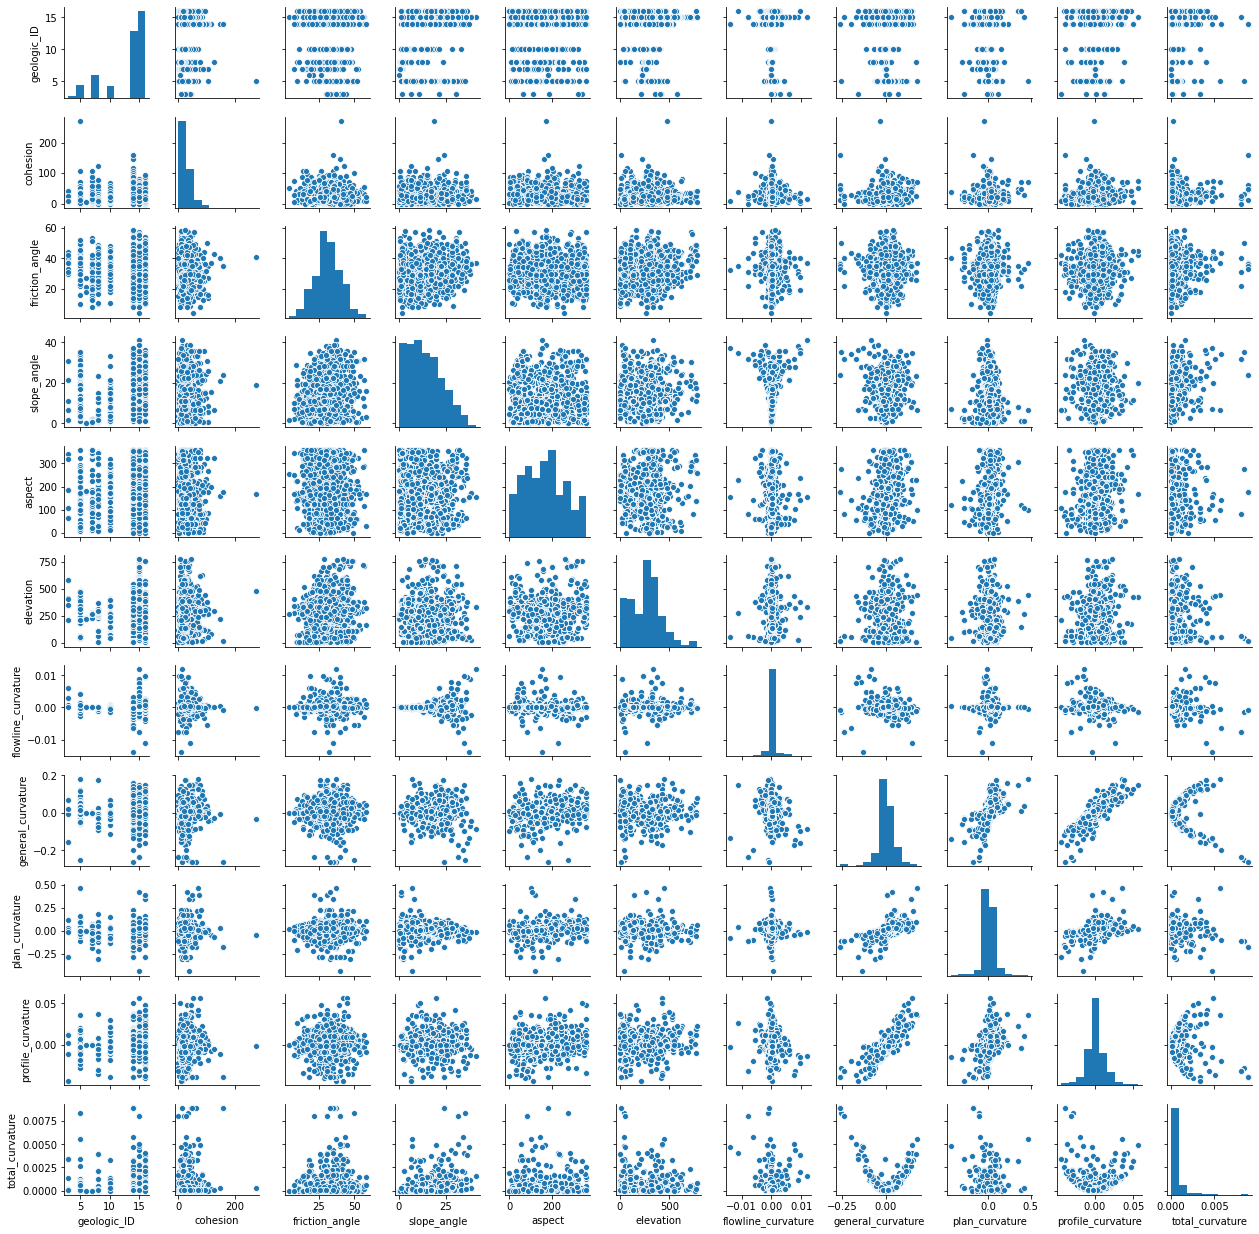

In [14]:
sns.pairplot(my_data_ss)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.3, hspace=0.2)
plt.show()

The non-linearity and weak correlation between features that can be observed in the plots may be due to different physical properties of geologic units lumped together. It is necessary to investigate each geologic unit for any signiificant relationships between features. 

Create subsets by geologic unit to evaluate any relationships between features

In [15]:
my_data_gg = my_data.iloc[:,[2,3,4,5,7,8,9,10,11,12,13,14]]
my_data_Qal1 = my_data_gg.loc[my_data_gg['geologic_unit']=='Qal1']
my_data_Qal1_ss=my_data_Qal1.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Qal2 = my_data_gg.loc[my_data_gg['geologic_unit']=='Qal2']
my_data_Qal2_ss=my_data_Qal2.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Qal3 = my_data_gg.loc[my_data_gg['geologic_unit']=='Qal3']
my_data_Qal3_ss=my_data_Qal3.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Qoa = my_data_gg.loc[my_data_gg['geologic_unit']=='Qoa']
my_data_Qoa_ss=my_data_Qoa.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Tsh = my_data_gg.loc[my_data_gg['geologic_unit']=='Tsh']
my_data_Tsh_ss=my_data_Tsh.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Tss = my_data_gg.loc[my_data_gg['geologic_unit']=='Tss']
my_data_Tss_ss=my_data_Tss.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Tv = my_data_gg.loc[my_data_gg['geologic_unit']=='Tv']
my_data_Tv_ss=my_data_Tv.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_Kss = my_data_gg.loc[my_data_gg['geologic_unit']=='Kss']
my_data_Kss_ss=my_data_Kss.iloc[:,[2,3,4,5,7,8,9,10,11]]
my_data_crystalline = my_data_gg.loc[my_data_gg['geologic_unit']=='crystalline']
my_data_crystalline_ss=my_data_crystalline.iloc[:,[2,3,4,5,7,8,9,10,11]]

Geologic unit counts by available borehole data in study area

In [16]:
my_data['geologic_unit'].value_counts()

Tsh            406
Tss            273
Tv             255
Kss             78
Qoa             76
Qal3            72
Qal2            67
crystalline     12
Qal1             3
Name: geologic_unit, dtype: int64

Correlation matrices of four geologic units that are representative of the general study area are plotted below - Tsh for tertiary units, Kss for cretaceous units, Qal3 for quaternary units, and crystalline.

In [17]:
plt.subplot(221)
corrMatrix = my_data_Tsh_ss.corr(method='pearson') # viewing Kss - cretaceous sandstone
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix for Tsh')

plt.subplot(222) 
corrMatrix = my_data_Kss_ss.corr(method='pearson') #viewing crystalline
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix for Kss')

plt.subplot(223) 
corrMatrix = my_data_Qal3_ss.corr(method='pearson') #viewing crystalline
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix for Qal3')

plt.subplot(224) 
corrMatrix = my_data_crystalline_ss.corr(method='pearson') #viewing crystalline
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix for crystalline')

plt.subplots_adjust(left=0.0, bottom=1.0, right=2.0, top=3.5, wspace=0.3, hspace=0.4)

plt.show()

When broken down by geologic units, slightly stronger correlations were observed between the predictor and response features, especially for Qal3 and crystalline.
crystalline, which is an older formation (so assumed to be stronger) seems to have a stronger correlation for cohesion and friction angle with elevation and slope geometric parameters when compared to Qal3

#### Conditional Statistics using Violin Plots
During consultation with Dr. Pyrcz, it was suggested that due to the weak correlation between the features, we separate cohesion and friction angle into low and high, and assess the difference in the conditional statistics.

Low cohesion < 20 kPa, low friction angle < 30 degrees

This is a more flexible method to compare the relationship between each predictor and response features. The features were standardized so their relative differences can be observed together.

Code block modified from Dr. Pyrcz's original Feature_ranking.ipynb

In [18]:
plt.subplot(121) #cohesion
my_data['tcohesion'] = np.where(my_data['cohesion']>=20, 'High', 'Low') # make a high and low production categorical feature

x = my_data[['geologic_ID','slope_angle','aspect','elevation','flowline_curvature','general_curvature','plan_curvature',
             'profile_curvature','total_curvature']]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([my_data['tcohesion'],x_stand.iloc[:,0:8]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="tcohesion",var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tcohesion", data=x,split=True, inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Cohesion')

plt.subplot(122) #friction angle
my_data['tfrict_angle'] = np.where(my_data['friction_angle']>=30, 'High', 'Low') # make a high and low production categorical feature

x = my_data[['geologic_ID','slope_angle','aspect','elevation','flowline_curvature','general_curvature','plan_curvature',
             'profile_curvature','total_curvature']]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([my_data['tfrict_angle'],x_stand.iloc[:,0:8]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="tfrict_angle",var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tfrict_angle", data=x,split=True, inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Friction Angle')

plt.subplots_adjust(left=0.0, bottom=1.0, right=2.5, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Both low and high cohesion show similar distributions for each feature. We see that there are significantly more outliers in the curvature features. "Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability".

#### Investigate the importance of the different features through Feature Ranking - Mutual Information

Code taken from Dr. Michael Pyrcz's Feature Selection workflow (available in the Github link below)

Feature ranking for Cohesion:
1. feature flowline_curvature = 1.000000
2. feature total_curvature = 0.964112
3. feature plan_curvature = 0.668014
4. feature elevation = 0.502874
5. feature general_curvature = 0.412787
6. feature profile_curvature = 0.269399
7. feature geologic_ID = 0.235650
8. feature slope_angle = 0.211152
9. feature aspect = 0.081256
Feature ranking for Friction Angle:
1. feature plan_curvature = 1.000000
2. feature general_curvature = 0.838269
3. feature elevation = 0.768217
4. feature slope_angle = 0.728721
5. feature total_curvature = 0.727029
6. feature flowline_curvature = 0.568124
7. feature geologic_ID = 0.553781
8. feature profile_curvature = 0.390851
9. feature aspect = 0.127205


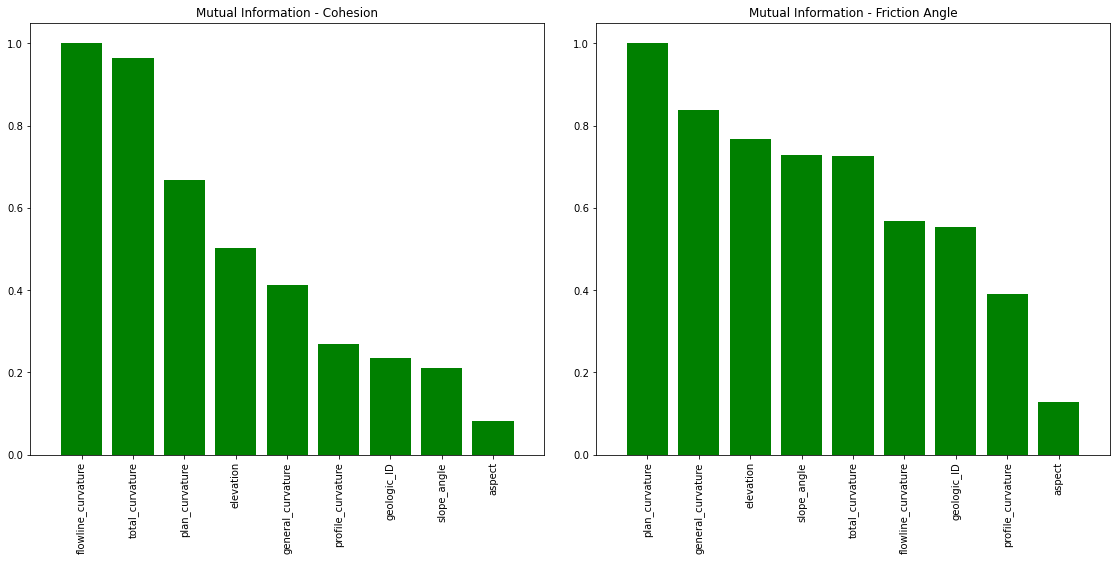

In [19]:
from sklearn.feature_selection import mutual_info_regression

x = my_data.iloc[:,[3,7,8,9,10,11,12,13,14]]              # separate DataFrame for predictor and response features
y1 = my_data.iloc[:,[4]]
y2 = my_data.iloc[:,[5]]

plt.subplot(121) #cohesion
mi_c = mutual_info_regression(x,np.ravel(y1)) # calculate mutual information
mi_c /= np.max(mi_c)                          # calculate relative mutual information
indices = np.argsort(mi_c)[::-1]            # find indicies for descending order
print("Feature ranking for Cohesion:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi_c[indices[f]]))
# plot the relative mutual information 
plt.title("Mutual Information - Cohesion")
plt.bar(range(x.shape[1]), mi_c[indices], color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])

plt.subplot(122) #friction angle
mi_phi = mutual_info_regression(x,np.ravel(y2)) 
mi_phi /= np.max(mi_phi)                          
indices = np.argsort(mi_phi)[::-1]            
print("Feature ranking for Friction Angle:")                 
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi_phi[indices[f]]))
plt.title("Mutual Information - Friction Angle")
plt.bar(range(x.shape[1]), mi_phi[indices], color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])

plt.subplots_adjust(left=0.0, bottom=1.0, right=2.5, top=2.5, wspace=0.1, hspace=0.2)
plt.show()

The larger values of mutual information indicate greater relationships between the response features (cohesion and friction angle) and the predictor features. The calculated values are greater than zero, which indicates that the features are not totally independent of one another.

It appears from the plot that geology and slope angle are not as important for predicting cohesion and friction angle when compared to curvature which contradicts engineering judgment. What is being obeserved here could be due to variability in geologic mapping or laboratory/field soil testing errors.

For the purpose of this project, the predictor features to model with have been reduced to plan curvature, total curvature, general curvature, elevation, slope angle and geologic ID.

Feature importance by geologic unit was not investigated for this project.

In [20]:
my_data_red=my_data.iloc[:,[3,4,5,7,9,11,12,14]] # Subset of borehole data for training and testing - reduced
my_data_red

geologic_ID  cohesion  friction_angle  slope_angle   elevation  \
0              14      7.20            28.0    11.404590  340.157715   
1              16     17.76            19.0    17.923658  116.392548   
2              16     52.80            31.0    21.327316  118.476265   
3              16     34.56            28.0    21.327316  118.476265   
4               3     43.20            37.5    21.496077  350.563263   
...           ...       ...             ...          ...         ...   
1237           15      9.60            28.0    11.224944  139.100388   
1238           15     21.60            29.0    11.224944  139.100388   
1239           15     46.80            35.0    17.110302  479.108673   
1240           15     42.00            30.0    17.110302  479.108673   
1241           15     20.64            26.0    17.110302  479.108673   

      general_curvature  plan_curvature  total_curvature  
0              0.004470        0.013357         0.000013  
1             -0.023428       -0.013017         0.000171  
2             -0.040145       -0.025920         0.000211  
3             -0.040145       -0.025920         0.000211  
4             -0.005612        0.029303         0.003362  
...                 ...             ...              ...  
1237          -0.015189        0.006325         0.000080  
1238          -0.015189        0.006325         0.000080  
1239           0.011698        0.026637         0.000096  
1240           0.011698        0.026637         0.000096  
1241           0.011698        0.026637         0.000096  

[1242 rows x 8 columns]

### Machine Learning Model
I selected Random Forest as my model for predicting shear strength parameters from the six predictor features. This is because Random Forest can be used for both numerical and categorical features (for when the response features are made categorical in future). It is easy to understand and does not require feature scaling or transformation. 

Random Forest is also able to manage outliers and non-linear features well, this helps in this project scenario. It is preferred over Decision Tree as it reduces model variance by averaging values.

#### Import packages

In [21]:
from sklearn.ensemble import RandomForestRegressor          # Random Forest method
from sklearn import metrics                                 # measure model performance
from sklearn import preprocessing                           # provides several common utility functions
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
from tqdm import tqdm_notebook                              # for iterations

#### First, predict cohesion

In [22]:
X = my_data_red.iloc[:,[0,3,4,5,6,7]].values              # separate DataFrames for predictor and response features
y = my_data_red.iloc[:,[1]].values

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=73073)

Instantiate, fit and predict Random Forest model

In [23]:
seed = 0                                                # set the random forest hyperparameters
max_depth = 75
num_tree = 10
max_features = 1

rdf_c1=RandomForestRegressor(max_depth=max_depth, n_estimators=num_tree,random_state=seed)
rdf_c1.fit(X_train,y_train)    # train the model with training data 

trainscore_c1 = rdf_c1.score(X_train, y_train)
testscore_c1 = rdf_c1.score(X_test, y_test)

print('\nModel Evaluation:')
print(f'Training Accuracy : {trainscore_c1}\nTest Accuracy : {testscore_c1}')


Model Evaluation:
Training Accuracy : 0.6197885001309282
Test Accuracy : -0.18470132302102238


Even though the training accuracy seems reasonable for a first try, the test accuracy is too low. An appropriate hyperparameter needs to be determined. In the case, the number of trees was used. 

#### Conduct hyperparameter tuning

Section of this code block was taken from https://github.com/kavyajeetbora/civil_engineering/blob/master/soil_rock_profile

In [24]:
%%time
seed = 0                                                # set the random forest hyperparameters
num_tree = np.arange(1,200,20)
cv_scores=[]

for tree in tqdm_notebook(num_tree):
    model=RandomForestRegressor(n_estimators=tree, random_state=seed)
    score=cross_val_score(model,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
    cv_scores.append(-1*np.mean(score))
    
opt_cv=num_tree[cv_scores.index(min(cv_scores))]
print(opt_cv)

plt.title('Hyperparameter Tuning for Random Forest Model')
plt.plot(num_tree,cv_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Cross Validation Score')
plt.show()

<timed exec>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



161


Wall time: 43.9 s


The optimal number of trees is 161. The model with the lowest mean squared error was chosen for prediction. The hyperparameter used was the number of trees for the random forest model.

Now predicting with the entire dataset

In [25]:
seed = 0                                                # set the random forest hyperparameters
max_depth = 75
num_tree = 161
max_features = 1

rdf_c2=RandomForestRegressor(max_depth=max_depth, n_estimators=num_tree,random_state=seed)
rdf_c2.fit(X,np.ravel(y))    # train the model with training data 

trainscore_c2 = rdf_c2.score(X_train, y_train)
testscore_c2 = rdf_c2.score(X_test, y_test)

print('\nModel Evaluation:')
print(f'Training Accuracy : {trainscore_c2}\nTest Accuracy : {testscore_c2}')


Model Evaluation:
Training Accuracy : 0.6109789119870181
Test Accuracy : 0.5385144883792126


#### Next, predict friction angle

In [26]:
X = my_data_red.iloc[:,[0,3,4,5,6,7]].values              # separate DataFrames for predictor and response features
y_phi = my_data_red.iloc[:,[2]].values

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_phi), test_size=0.2, random_state=73073)

Instantiate, fit and predict Random Forest model

In [27]:
seed = 0                                                # set the random forest hyperparameters
max_depth = 75
num_tree = 10
max_features = 1

rdf_phi1=RandomForestRegressor(max_depth=max_depth, n_estimators=num_tree,random_state=seed)
rdf_phi1.fit(X_train,y_train)    # train the model with training data 

trainscore_phi1 = rdf_phi1.score(X_train, y_train)
testscore_phi1 = rdf_phi1.score(X_test, y_test)

print('\nModel Evaluation:')
print(f'Training Accuracy : {trainscore_phi1}\nTest Accuracy : {testscore_phi1}')


Model Evaluation:
Training Accuracy : 0.6736329193159215
Test Accuracy : 0.06264243603435093


Model accuracy for friction angle is slightly better. It could be because friction angle showed better correlation with predictor features than cohesion. 

Conduct hyperparamter tuning

<timed exec>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



181


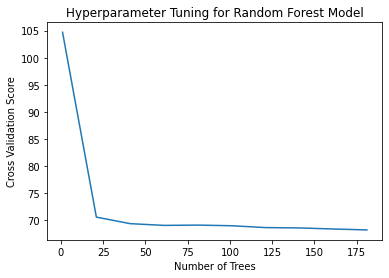

Wall time: 47.9 s


In [28]:
%%time
seed = 0                                                # set the random forest hyperparameters
num_tree = np.arange(1,200,20)
cv_scores_phi=[]

for tree in tqdm_notebook(num_tree):
    model_phi=RandomForestRegressor(n_estimators=tree, random_state=seed)
    score=cross_val_score(model_phi,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
    cv_scores_phi.append(-1*np.mean(score))
    
opt_cv_phi=num_tree[cv_scores_phi.index(min(cv_scores_phi))]
print(opt_cv_phi)

plt.title('Hyperparameter Tuning for Random Forest Model')
plt.plot(num_tree,cv_scores_phi)
plt.xlabel('Number of Trees')
plt.ylabel('Cross Validation Score')
plt.show()

The optimal number of trees is 181. The model with the lowest mean squared error was chosen for prediction. The hyperparameter used was the number of trees for the random forest model.

Now predicting with the entire dataset

In [29]:
seed = 0                                                # set the random forest hyperparameters
max_depth = 75
num_tree = 181
max_features = 1

rdf_phi2=RandomForestRegressor(max_depth=max_depth, n_estimators=num_tree,random_state=seed)
rdf_phi2.fit(X,np.ravel(y_phi))    # train the model with training data 

trainscore_phi2 = rdf_phi2.score(X_train, y_train)
testscore_phi2 = rdf_phi2.score(X_test, y_test)

print('\nModel Evaluation:')
print(f'Training Accuracy : {trainscore_phi2}\nTest Accuracy : {testscore_phi2}')


Model Evaluation:
Training Accuracy : 0.6942587252733449
Test Accuracy : 0.7597772709469552


### Results

Based on available borehole data for the Point Dume area, cohesion and friction angle were predicted from geology and slope geometry using Random Forest algorithm. Two models were built, one for cohesion and the other for friction angle. The training and testing accuracies for cohesion were about 61% and 54% respectively, while for friction angle, approx. 70% and 76% respectively. The higher accuracy with friction angle may be due to friction angle showing a better correlation with predictor features than cohesion. 

In conclusion, this is just the first of many steps in exploring the relationship between soil engineering properties, geology and slope geometric properties. Further analyses will be conducted using data from different study areas and utilizing other machine learning algorithms. Emphasis will be placed on training models with data that includes soil physical properties such as unit weight, grain size, water content, etc. where available.  


I hope this was helpful,

Laide Ojomo

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
